# Random Forest with Spark and others

# Spark implementation

In [3]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

Пра дадзеныя: невялікі датасэт, на 770 запісаў. Распавядае нам пра людзей, іх стан і тое, ці маюць яны дыябет.\
Там значна ніжэй, дзе пачынаецца NotSpark implementation, я зрабіў невялічкі аналіз выбаркі, яна не сбалансаваная, вось рэзультаты:\
% of people in safe:  65.10416666666667\
% of people in dangerous:  34.895833333333336

In [213]:
file_name = 'pima-indians-diabetes.csv'

In [214]:

data = spark.read.csv(file_name, header=False, inferSchema=True)

In [215]:
data = data.withColumnRenamed('_c8', 'label')
data.show(3)

+---+---+---+---+---+----+-----+---+-----+
|_c0|_c1|_c2|_c3|_c4| _c5|  _c6|_c7|label|
+---+---+---+---+---+----+-----+---+-----+
|  6|148| 72| 35|  0|33.6|0.627| 50|    1|
|  1| 85| 66| 29|  0|26.6|0.351| 31|    0|
|  8|183| 64|  0|  0|23.3|0.672| 32|    1|
+---+---+---+---+---+----+-----+---+-----+
only showing top 3 rows



In [216]:
from pyspark.ml.feature import VectorAssembler

feature_columns = data.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")

In [217]:
data_2 = assembler.transform(data)

In [218]:
data_2.show()

+---+---+---+---+---+----+-----+---+-----+--------------------+
|_c0|_c1|_c2|_c3|_c4| _c5|  _c6|_c7|label|            features|
+---+---+---+---+---+----+-----+---+-----+--------------------+
|  6|148| 72| 35|  0|33.6|0.627| 50|    1|[6.0,148.0,72.0,3...|
|  1| 85| 66| 29|  0|26.6|0.351| 31|    0|[1.0,85.0,66.0,29...|
|  8|183| 64|  0|  0|23.3|0.672| 32|    1|[8.0,183.0,64.0,0...|
|  1| 89| 66| 23| 94|28.1|0.167| 21|    0|[1.0,89.0,66.0,23...|
|  0|137| 40| 35|168|43.1|2.288| 33|    1|[0.0,137.0,40.0,3...|
|  5|116| 74|  0|  0|25.6|0.201| 30|    0|[5.0,116.0,74.0,0...|
|  3| 78| 50| 32| 88|31.0|0.248| 26|    1|[3.0,78.0,50.0,32...|
| 10|115|  0|  0|  0|35.3|0.134| 29|    0|[10.0,115.0,0.0,0...|
|  2|197| 70| 45|543|30.5|0.158| 53|    1|[2.0,197.0,70.0,4...|
|  8|125| 96|  0|  0| 0.0|0.232| 54|    1|[8.0,125.0,96.0,0...|
|  4|110| 92|  0|  0|37.6|0.191| 30|    0|[4.0,110.0,92.0,0...|
| 10|168| 74|  0|  0|38.0|0.537| 34|    1|[10.0,168.0,74.0,...|
| 10|139| 80|  0|  0|27.1|1.441| 57|    

In [282]:
train, test = data_2.randomSplit([0.7, 0.3], seed=233)

In [246]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import BinaryClassificationEvaluator 

In [221]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module pyspark.ml.classification:

class RandomForestClassifier(pyspark.ml.wrapper.JavaEstimator, pyspark.ml.param.shared.HasFeaturesCol, pyspark.ml.param.shared.HasLabelCol, pyspark.ml.param.shared.HasPredictionCol, pyspark.ml.param.shared.HasSeed, pyspark.ml.param.shared.HasRawPredictionCol, pyspark.ml.param.shared.HasProbabilityCol, pyspark.ml.regression.RandomForestParams, TreeClassifierParams, pyspark.ml.param.shared.HasCheckpointInterval, pyspark.ml.util.JavaMLWritable, pyspark.ml.util.JavaMLReadable)
 |  RandomForestClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', probabilityCol='probability', rawPredictionCol='rawPrediction', maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, maxMemoryInMB=256, cacheNodeIds=False, checkpointInterval=10, impurity='gini', numTrees=20, featureSubsetStrategy='auto', seed=None, subsamplingRate=1.0)
 |  
 |  `Random Forest <http://en.wikipedia.org/wiki/Random_forest>

### Default RandomForestClassifier

In [283]:
rf = RandomForestClassifier(labelCol='label', featuresCol="features")

Тут, канешне, так сабе пайплайн, усяго з адной ступенню, але які ёсць

In [284]:
pipeline = Pipeline(stages=[rf])

In [285]:
%%time
model = pipeline.fit(train)

Wall time: 1.77 s


In [286]:
%%time
predictions = model.transform(test)

Wall time: 199 ms


In [287]:
predictions.select("label", "prediction").show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 10 rows



In [288]:
evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction")
standard_accuracy_roc = evaluator.evaluate(predictions)

In [289]:
evaluator.getMetricName()

'areaUnderROC'

In [290]:
standard_accuracy_roc

0.8079582474569517

In [291]:
evaluator.setMetricName('areaUnderPR')
standard_accuracy_pr = evaluator.evaluate(predictions)
standard_accuracy_pr

0.7044998642442541

*Чамусьці ў BinaryClassificationEvaluator ё толькі дзве гэтыя метрыкі, больш няма. Другая щвогуле малараспаўсюджаная.*

### Grid through parameters in RandomForestClassifier

In [292]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [293]:
rf = RandomForestClassifier(labelCol='label', featuresCol="features")
pipeline = Pipeline(stages=[rf])

In [233]:
%%time
paramGrid = ParamGridBuilder().addGrid(rf.numTrees, [100, 200, 300]).addGrid(rf.maxBins, [32, 64, 128]).addGrid(rf.maxDepth,[5, 10, 20]).build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5) 

cvModel = crossval.fit(data_2)

Wall time: 8min 1s


##### Воьс прыблізна столькі на гэтым датасэце і маім слабым камп'ютары заняў пошук лепшых параметраў, з 27 рознымі канфігурацыямі і 5-фолд валідацыяй.

In [234]:
print(type(cvModel))
cvModel.avgMetrics

<class 'pyspark.ml.tuning.CrossValidatorModel'>


[0.8347954270314932,
 0.8283731993323638,
 0.8255025134592198,
 0.8419463350535121,
 0.8336457287398729,
 0.8327314297313286,
 0.8425275770007015,
 0.8346027758157477,
 0.8314479359338092,
 0.8369377951281737,
 0.8368779858058869,
 0.837337728588565,
 0.8406953351694999,
 0.8319710937455133,
 0.8308763362918935,
 0.8395962377266448,
 0.8368078932683352,
 0.8328624406691981,
 0.8422427878926466,
 0.8366830161418526,
 0.834232616732181,
 0.8428661727740268,
 0.8414521529817844,
 0.8398795522979523,
 0.8413511509008278,
 0.8333847546472761,
 0.8333665812981119]

##### Паглядзім на канфігурацыю лепшай мадэлі:


In [294]:
max_depth = cvModel.bestModel.stages[-1]._java_obj.getMaxDepth()
print("Max Depth = ", max_depth)
num_trees = cvModel.bestModel.stages[-1]._java_obj.getNumTrees()
print("Num of Trees = ", num_trees)
max_bins = cvModel.bestModel.stages[-1]._java_obj.getMaxBins()
print("Max Bins = ", max_bins)


Max Depth =  5
Num of Trees =  100
Max Bins =  64



Пабудуем мадэль зноў, каб навучыць яе на трэйне і праверыць на тэсце, бо інакш параўнанне дакладнасці двух мадэляў не будзе шчырым.

In [295]:
rf = RandomForestClassifier(labelCol='label', featuresCol="features", maxBins=max_bins, maxDepth=max_depth, numTrees=num_trees)
pipeline = Pipeline(stages=[rf])

In [296]:
%%time
model = pipeline.fit(train)

Wall time: 1.83 s


In [297]:
%%time
predictions = model.transform(test)

Wall time: 103 ms


In [298]:
evaluator = BinaryClassificationEvaluator(
    labelCol="label", rawPredictionCol="rawPrediction")
evaluator.setMetricName('areaUnderROC')
grid_accuracy_roc = evaluator.evaluate(predictions)
print("Metric: areaUnderROC")
print(f"Standard configuration on test: {standard_accuracy_roc}")
print(f"Best parameters by griding: {grid_accuracy_roc}")

evaluator.setMetricName('areaUnderPR')
grid_accuracy_pr = evaluator.evaluate(predictions)
print("\nMetric: areaUnderPR")
print(f"Standard configuration on test: {standard_accuracy_pr}")
print(f"Best parameters by griding: {grid_accuracy_pr}")

Metric: areaUnderROC
Standard configuration on test: 0.8079582474569517
Best parameters by griding: 0.8218203576889841

Metric: areaUnderPR
Standard configuration on test: 0.7044998642442541
Best parameters by griding: 0.7109505838078012


**Змаглі крыху палепшыць рэзультат, але не моцна.**

In [309]:
spark.stop()

# NotSpark implementation

In [357]:
from sklearn.ensemble import RandomForestClassifier as RandForestClf
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
import sklearn

from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt

In [303]:
data = pd.read_csv(file_name, header=None)

In [305]:
data.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [306]:
data.head(3)

,0,1,2,3,4,5,6,7,8
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


Тут можна паглядзець на тое, як у нас дадзеныя размеркаваныя ў датасэце.
Гэта варта было зрабіць у самым пачатку, але я быў заняты тым, што прадзіраўся праз спарк, таму лепей позна, чым ніколі. 

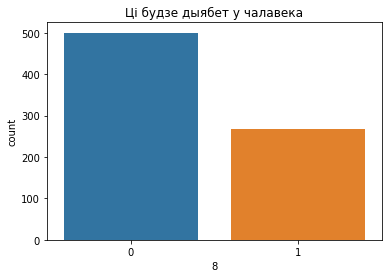

In [341]:
plt.subplots(figsize=(6,4))
sns.countplot(x=8, data=data)
plt.title("Ці будзе дыябет у чалавека")
plt.show()

In [344]:
n=len(data)
l_0=len(data[data[8]==0])
l_1=len(data[data[8]==1])

print("% of people in safe: ",surv_0*100/n)
print("% of people in dangerous: ",surv_1*100/n)

% of people in safe:  65.10416666666667
% of people in dangerous:  34.895833333333336


In [323]:
x = data[data.columns[:-1]]
y = data[data.columns[-1]]

In [324]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### Standard Random Forest from sklearn

In [330]:
random_forest = RandForestClf(random_state=12)

In [331]:
%%time
random_forest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [332]:
%%time
y_pred=random_forest.predict(x_test)

In [370]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("ROC: ", sklearn.metrics.roc_auc_score(y_test, y_pred ))

Accuracy: 0.7445887445887446
ROC:  0.6909250879839115


### Grid Parameters

In [360]:
param_grid = { 
    'n_estimators': [100, 200, 300],
    'max_depth' : [4, 5, 6, 10, 20],
    'criterion' :['gini', 'entropy'],
    'max_features' :['auto', 'sqrt'],
    'min_samples_split' :[2, 5, 10],
    'min_samples_leaf' :[1, 2, 4],
    'bootstrap' :[True, False]
}

1080 канфігурацый, ну пагналі

In [361]:
%%time
rand_forest_grid = RandForestClf(random_state=12)
cv_rfc = GridSearchCV(estimator=rand_forest_grid, param_grid=param_grid, cv= 5)
cv_rfc.fit(x_train, y_train)

Wall time: 54min 30s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [362]:
cv_rfc.best_params_

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 100}

In [363]:
grid_best_rf = RandForestClf(random_state=12, criterion='entropy', max_depth=20, n_estimators=100, max_features='auto', min_samples_split=5, min_samples_leaf=2,bootstrap=True)

In [364]:
grid_best_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12, verbose=0,
                       warm_start=False)

In [365]:
predictions = grid_best_rf.predict(x_test)

In [369]:
print("Accuracy for Random Forest: ", sklearn.metrics.accuracy_score(y_test,predictions))
print("ROC: ", sklearn.metrics.roc_auc_score(y_test,predictions))

Accuracy for Random Forest:  0.7835497835497836
ROC:  0.7360482654600302


### Вынікі і думкі
Sklearn на грыдзе працаваў хутчэй за спарк, таму я дадаў больш параметраў для перабору, у выніку тут перабор займае болей часу. Гэта вельмі прыблізна, але:\
    спарк: 27 канфігурацый ~ 10 хвілін -> 2,7 канфігурацыі/хвіліну\
    sklearn: 1080 канфігурацый ~ 54 хвіліны -> 20 канфігурацый/хвіліну

Пэўна, спарк вельмі хуткі на кластэрах, але для запуску лакальна лепей карыстацца іншымі мл-лібамі.

Дзіўна крыху, што калі параўноўваць метрыкі, то ў спарку ROC-метрыка вышэй за склёрн на амаль на 10% (0.82 > 0.74). Прычым на спарку мы перабралі мала параметраў, у адрозненні ад склёрн. Можа, там розныя алгарытмы падліку ці так няўдачна атрымалася разбіць датасэт у склёрне. Не ведаю.\
Таксама мяне здзівіла, што для ў ацэншчыка бінарнай класіфікацыі няма звычайнай accuracy-метрыкі. Хаця ў нас датасэт не сбалансаваны, таму нам не вельмі яна патрэбная, гэтая аккурасі, канешне.\
Дзіўна, тут нейкая анамальная перамога спарка. Лес у склёрне так дрэнна рэалізаваны ці гэта мае рукі не вельмі рэалізаваныя, я не магу сказаць.

Асалоды больш атрымаў не на спарку, бо штохвілінныя памылкі з хвастамі джава-экспэпшынаў на 40 радкоў моцна бянтэжаць. Плюс усё не зусім звычайна, не ведаеш, чым карыстацца, а дакументацыя спарка не самая лепшая, як мне падалося. Ну і вы паглядзіце, як я даставаў лепшыя параметры пры грыдзе ў спарку, гэта ж дзіч. 
Але, напэўна, гэта справа звычкі. Калі некалькі разоў папрацуеш, будзе лепей.